![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

def MSE(y, y_pred):
    if y.shape[0] == 0:
        return 0   
    else:
        mse = ((y-y_pred)**2).mean()
        return mse
    
def mse_split(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_l = MSE(y_l, y_l.mean())
    mse_r = MSE(y_r, y_r.mean())
    
    mse_ = mse_l + mse_r
   
    return mse_


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])

    # se determina como mejor split inicial np.inf ya que es el valor mas alto que se puede generar
    best_split = [0, 0, np.inf]  # j, split, min_mse

    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            mse = mse_split(X.iloc[:, j], y, split)
            
            if mse < best_split[2]:
                best_split = [j, split, mse]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, max_depth=None, num_pct=100, min_samples = 3):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.mean() , level=level, split=-1, n_samples=1, mse=MSE(y,y.mean()))
        return tree
    
    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)
    
    # estimar la predicción
    y_pred = y.mean()    
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse)
    # Revisar el criterio de parada - se añade split = 0 cuando se determina que no hay mas divisiones por hacer 
    if X.shape[0] < min_samples:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    if split == 0:
        return tree
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    #print(level)
    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct, min_samples = 3)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct, min_samples = 3)

    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [6]:
tree_mnl = tree_grow(X_train, y_train, level=0, max_depth=None, num_pct=100, min_samples = 3)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_predict_tree = tree_predict(X_test, tree_mnl)

mae_mnl_tree = mean_absolute_error(y_test, y_predict_tree)
rmse_mnl_tree = np.sqrt(mean_squared_error(y_test, y_predict_tree))


resultados_modelos = {}
resultados_modelos['arbol_manual'] = {'MAE':mae_mnl_tree,
                                           'RMSE': rmse_mnl_tree}


print(mae_mnl_tree, rmse_mnl_tree)

1738.999326404927 2318.2956396925965


In [8]:
y_train.describe()

count     7031.000000
mean     14508.073389
std       3927.667432
min       5002.000000
25%      11998.000000
50%      15000.000000
75%      16996.000000
max      32444.000000
Name: Price, dtype: float64

El modelo de arbol de decisión presenta un error promedio absoluto de *1738* lo cual implicaque en promedio de las predicciones realizadas estas se equivocan de su valor real por +/- este valor que para la magnitud de la variable **$y$** no es un error tan alto ya que los precios de los automoviles en promedio se encuentran en el orden de los *14500*.
El arbol de decision tiene un buen comportamiento sin embargo su tiempo de ejecución es alto ya que la implementacion manual realizada no tiene en cuenta optimizaciones para el lenguaje utilizado

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2

# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]



# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred_bag_df = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_i = X_train.iloc[sample,:]
    y_train_i = y_train.iloc[sample]
    treereg.fit(X_train_i, y_train_i)
    y_pred_bag_df.iloc[:,i] = treereg.predict(X_test)
    
for i in range(n_B):
    print('Árbol ', i, 'tiene un error rmse: ', np.sqrt(mean_squared_error(y_test, y_pred_bag_df.iloc[:,i])))
    print('Árbol ', i, 'tiene un error mae: ', mean_absolute_error(y_test, y_predict_tree))

Árbol  0 tiene un error rmse:  2141.613353645869
Árbol  0 tiene un error mae:  1738.999326404927
Árbol  1 tiene un error rmse:  2136.3519863123465
Árbol  1 tiene un error mae:  1738.999326404927
Árbol  2 tiene un error rmse:  2122.718759132052
Árbol  2 tiene un error mae:  1738.999326404927
Árbol  3 tiene un error rmse:  2087.278992468617
Árbol  3 tiene un error mae:  1738.999326404927
Árbol  4 tiene un error rmse:  2168.518742842026
Árbol  4 tiene un error mae:  1738.999326404927
Árbol  5 tiene un error rmse:  2113.8811455834793
Árbol  5 tiene un error mae:  1738.999326404927
Árbol  6 tiene un error rmse:  2127.933470769012
Árbol  6 tiene un error mae:  1738.999326404927
Árbol  7 tiene un error rmse:  2184.414847251443
Árbol  7 tiene un error mae:  1738.999326404927
Árbol  8 tiene un error rmse:  2138.1071697514985
Árbol  8 tiene un error mae:  1738.999326404927
Árbol  9 tiene un error rmse:  2132.097520859104
Árbol  9 tiene un error mae:  1738.999326404927


In [10]:
y_pred = y_pred_bag_df.mean(axis=1)


mae_mnl_bagg = mean_absolute_error(y_test, y_pred)
rmse_mnl_bagg = np.sqrt(mean_squared_error(y_test, y_pred))

resultados_modelos['bagging_manual'] = {'MAE':mae_mnl_bagg,
                                           'RMSE': rmse_mnl_bagg}

print(mae_mnl_bagg, rmse_mnl_bagg)

1340.0160739030025 1796.4355868399332


En esta implementacion se utiliza el arbol de decision implementado en sklearn, y vemos que para cada iteracion del arbol se obtenen un *MAE y RMSE* similaral obtenido en la implementacion manual, lo cual corrobora que la implementación realizada anteriormente es correcta, ademas se observa que para todos los arboles el error es similar entre si. Cuando la prediccion de cada arbol es promediada para completar el proceso de bagging se ve que las dos medidas MAE y RMSE se reducen, evidenciando los beneficios del metodo de *Boosting* en el cual al tomar distintos muestreos para el entreno de cada arbol y juntarlos al final se mitigan los sesgos aprendidos por cada arbol y se obtiene un resultado más robusto y con un mejor desempeño



### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [56]:
# Celda 3

from sklearn.ensemble import BaggingRegressor
import math 

n_features = X_train.shape[1]

max_variables = int(math.log2(X.shape[1]))
#max_variables = X_train.shape[1]

bagreg = BaggingRegressor(DecisionTreeRegressor(max_depth=None, random_state=123), n_estimators=10, max_features = max_variables, 
                          bootstrap=True, oob_score=True, random_state=1)

bagreg.fit(X_train,y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=123),
                 max_features=3, oob_score=True, random_state=1)

In [57]:
y_pred = bagreg.predict(X_test)

mae_mnl_bagg_sk = mean_absolute_error(y_test, y_pred)
rmse_mnl_bagg_sk = np.sqrt(mean_squared_error(y_test, y_pred))


resultados_modelos['bagging_libreria'] = {'MAE':mae_mnl_bagg_sk,
                                           'RMSE': rmse_mnl_bagg_sk}

print(mae_mnl_bagg_sk, rmse_mnl_bagg_sk)

1523.7936523039218 2013.353269091173


de forma general para el problema de regresión el parametro *max_features* se escoge en un rango entre [p/3, p] donde p es el numero de variables. En este caso segun el resultado se ve que es mejor tener la totalidad de las variables que una fraccion.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación  y comenten sobre el desempeño del modelo.

In [13]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

randF = RandomForestRegressor(random_state=10, n_estimators=100)

randF.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [14]:
y_pred = randF.predict(X_test)

mae_randF = mean_absolute_error(y_test, y_pred)
rmse_randF = np.sqrt(mean_squared_error(y_test, y_pred))


resultados_modelos['random_forest_libreria'] = {'MAE':mae_randF,
                                           'RMSE': rmse_randF}


print(mae_randF, rmse_randF)

1309.6517446910125 1762.5549543508685


Random Forest tiene el mejor desempeño respecto a los modelos anteriores. El hecho de que ya no se usen todas las variables en el ajuste del modelo y los parámetros internos es lo que mejora el modelo. Respecto a los árboles manuales y el boosting manual de los 10 árboles, random forest tiene por defecto la raiz cuadrada del total de variables. El usar menos variables evita que los árboles estén altamente correlacionados.
Este modelo se está equivocando en promedio 1.309 dólares por arriba o por debajo del valor real del vehículo. Así mismo, este modelo maneja un score, calculado a partir del MSE, de 1763.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### n_estimators

In [15]:
# Celda 5

estimators_arr = np.arange(1,1000,10)
mae_arr = []
rmse_arr = []

for i in estimators_arr:
    randF = RandomForestRegressor(random_state=10, n_estimators=i, n_jobs=-1)
    randF.fit(X_train, y_train)
    y_pred_i = randF.predict(X_test)
    mae_randF = mean_absolute_error(y_test, y_pred_i)
    rmse_randF = np.sqrt(mean_squared_error(y_test, y_pred_i))

    mae_arr.append(mae_randF)
    rmse_arr.append(rmse_randF)

mejor parametro n_estimators: 291
valor de rmse para el mejor parametro: 1756.086106169565


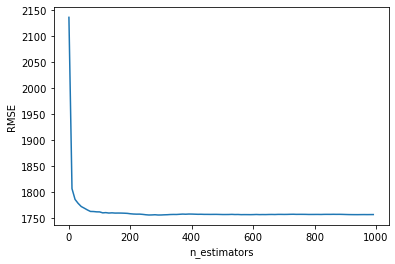

In [16]:
print("mejor parametro n_estimators: {}".format(estimators_arr[np.argmin(rmse_arr)]))
print("valor de rmse para el mejor parametro: {}".format(rmse_arr[np.argmin(rmse_arr)]))
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimators_arr, rmse_arr)
plt.xlabel('n_estimators')
plt.ylabel('RMSE');

#### max_depth

In [17]:
# Celda 5

depth_arr = np.arange(1,20,1)
mae_arr = []
rmse_arr = []

for i in depth_arr:
    randF = RandomForestRegressor(random_state=10, n_jobs=-1, n_estimators=291, max_depth=i)
    randF.fit(X_train, y_train)
    y_pred_i = randF.predict(X_test)
    mae_randF = mean_absolute_error(y_test, y_pred_i)
    rmse_randF = np.sqrt(mean_squared_error(y_test, y_pred_i))

    mae_arr.append(mae_randF)
    rmse_arr.append(rmse_randF)

mejor parametro para max_depth: 1564.7632441888525
valor de rmse para el mejor parametro: 8


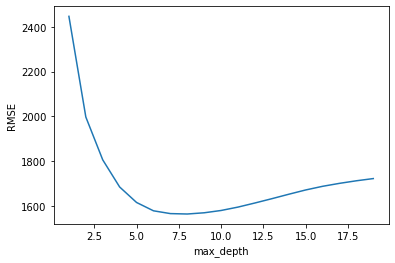

In [18]:
print("mejor parametro para max_depth: {}".format(rmse_arr[np.argmin(rmse_arr)]))
print("valor de rmse para el mejor parametro: {}".format(depth_arr[np.argmin(rmse_arr)]))
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(depth_arr, rmse_arr)
plt.xlabel('max_depth')
plt.ylabel('RMSE');

#### max_features

In [19]:
# Celda 5

features_arr = np.arange(1,X_train.shape[1],1)
mae_arr = []
rmse_arr = []

for i in features_arr:
    randF = RandomForestRegressor(random_state=10, n_jobs=-1, n_estimators=291, max_depth=8, max_features=i)
    randF.fit(X_train, y_train)
    y_pred_i = randF.predict(X_test)
    mae_randF = mean_absolute_error(y_test, y_pred_i)
    rmse_randF = np.sqrt(mean_squared_error(y_test, y_pred_i))

    mae_arr.append(mae_randF)
    rmse_arr.append(rmse_randF)

mejor parametro para max_features: 1552.6020335420355
valor de rmse para el mejor parametro: 5


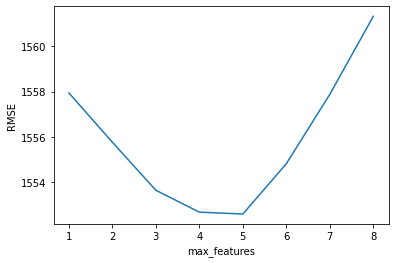

In [20]:
print("mejor parametro para max_features: {}".format(rmse_arr[np.argmin(rmse_arr)]))
print("valor de rmse para el mejor parametro: {}".format(features_arr[np.argmin(rmse_arr)]))
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(features_arr, rmse_arr)
plt.xlabel('max_features')
plt.ylabel('RMSE');

In [21]:
from sklearn.model_selection import GridSearchCV

RandF = RandomForestRegressor(random_state=10, n_jobs=-1)
parameters = {'n_estimators': np.arange(1,300,100),
              'max_depth':depth_arr,
              'max_features': [1,3,5,8]
              }
RF_grid = GridSearchCV(RandF,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=2,
                        scoring = 'neg_mean_squared_error')

RF_grid.fit(X_train,y_train)
y_pred = RF_grid.predict(X_test)

Fitting 5 folds for each of 228 candidates, totalling 1140 fits


In [22]:
RF_grid.best_params_

{'max_depth': 8, 'max_features': 5, 'n_estimators': 201}

In [23]:
mae_randF = mean_absolute_error(y_test, y_pred)
rmse_randF = np.sqrt(mean_squared_error(y_test, y_pred))


resultados_modelos['random_forest_best'] = {'MAE':mae_randF,
                                           'RMSE': rmse_randF}


print(mae_randF, rmse_randF)

1138.4220248934055 1552.1727580835422


Se reconoce que cada parametro afecta de una manera diferente el desempeño del modelo:
   1. n_estimators: este parámetro determina el número de árboles en el bosque aleatorio. Un valor más alto aumentará la precisión del modelo, pero también aumentará el costo computacional. Por esta razon el RMSE continua disminuyendo mientras más estimadores se agregan. Sin embargo, después de cierto punto no es eficiente continuar con este incremento (291)
   2. max_depth: este parámetro controla la profundidad máxima del árbol de decisión. Un valor más alto permite que el modelo aprenda relaciones más complejas en los datos, pero también puede conducir al sobreajuste. Esto se puede observar en los efectos observados en la gráfica donde el RMSE después de haber disminuido hasta cierto punto empieza a incrementarse de nuevo (8). Esto significa que durante la selección de los parametros se debe ser cuidadoso en la profundidad que se va a seleccionar
   3. max_features: este parámetro controla el número máximo de características que se utilizan en cada división del árbol. Un valor más alto permitirá que el modelo tenga más información para tomar decisiones, pero también puede conducir al overfitting. Esto se puede observar en el efecto que tiene el incremento de las variables despúes de cierto punto (Posterior a 5).

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn y comenten sobre el desempeño del modelo.

In [24]:
# Celda 6

# Importación y definición de modelo XGBClassifier

from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

clf = XGBRegressor()

# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


mae_XBoost = mean_absolute_error(y_test, y_pred)
rmse_XBoost = np.sqrt(mean_squared_error(y_test, y_pred))


resultados_modelos['XGBoost'] = {'MAE':mae_XBoost,
                                           'RMSE': rmse_XBoost}


print(mae_XBoost, rmse_XBoost)

1186.634392366123 1621.4197004256812


El desempeño de XGBoost frente a los modelos anteriores, no tiene una mejora considerable, dado que los valores por defecto del modelo no logran mejorar los parámetros óptimos de un Random Forest. Sin embargo, es de resaltar que el modelo que se obtuvo por defecto de XGBoost supera el modelo obtenido por defecto de Random Forest, que tuvo un MAE de 1.309 y un score de 1762. Esto quiere decir que los parámetros de regularización de XGBoost logran una mejora en el rendimiento.
Este modelo se está equivocando en promedio 1.187 dólares por arriba o por debajo del valor real del vehículo. Así mismo, este modelo maneja un score, calculado a partir del MSE, de 1621.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

La mejor tasa de aprendizaje para el modelo es igual a 0.0661


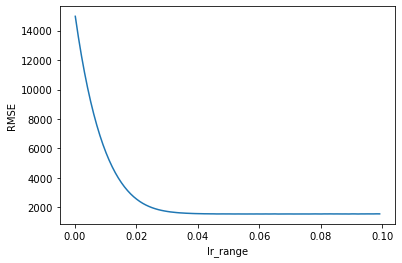

In [25]:
# Celda 7

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
lr_range = np.arange(0.0001, 0.1, 0.001)

# Definición de lista para almacenar el mae y rmse para cada valor de n_estimators
mae_arr = []
rmse_arr = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for lr in lr_range:
    clf = XGBRegressor(learning_rate=lr,random_state=1, n_jobs=-1)
    #accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5).mean())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_arr.append(mae)
    rmse_arr.append(rmse)


    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(lr_range, rmse_arr)
plt.xlabel('lr_range')
plt.ylabel('RMSE')



mensaje = ['La mejor tasa de aprendizaje para el modelo es igual a',str(lr_range[np.argmin(rmse_arr)])]
print(" ".join(mensaje))

La mejor gamma para el modelo es igual a 9000.0


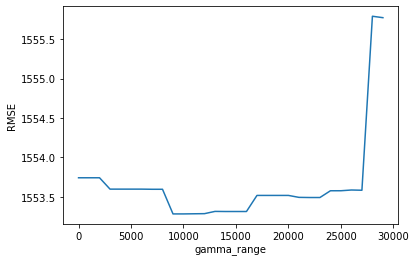

In [26]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
gamma_range = np.arange(0, 30e3, 1000)
#gamma_range = np.logspace(-10, 5, num=20)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
mae_arr = []
rmse_arr = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for gamma in gamma_range:
    clf = XGBRegressor(learning_rate=0.0661, gamma=gamma, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_arr.append(mae)
    rmse_arr.append(rmse)
    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(gamma_range, rmse_arr)
plt.xlabel('gamma_range')
plt.ylabel('RMSE')

mensaje = ['La mejor gamma para el modelo es igual a',str(gamma_range[np.argmin(rmse_arr)])]
print(" ".join(mensaje))

La mejor fracción de variables por árbol para el modelo es igual a 0.23


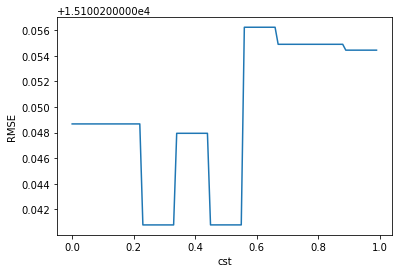

In [27]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
cst_range = np.arange(0, 1, 0.01)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
mae_arr = []
rmse_arr = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for cst in cst_range:
    clf = XGBRegressor(learning_rate=0.0661, gamma=9e3, colsample_bytree=cst, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train/1000)
    y_pred = clf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_arr.append(mae)
    rmse_arr.append(rmse)
    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(cst_range, rmse_arr)
plt.xlabel('cst')
plt.ylabel('RMSE')

mensaje = ['La mejor fracción de variables por árbol para el modelo es igual a',str(cst_range[np.argmin(rmse_arr)])]
print(" ".join(mensaje))

In [28]:
clf = XGBRegressor(learning_rate=0.0661, gamma=9e3, colsample_bytree=0.56, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

mae_best_XGBoost = mean_absolute_error(y_test, y_pred)
rmse_best_XGBoost = np.sqrt(mean_squared_error(y_test, y_pred))


resultados_modelos['best_XGBoost'] = {'MAE':mae_best_XGBoost,
                                           'RMSE': rmse_best_XGBoost}

print(mae_best_XGBoost, rmse_best_XGBoost)

1131.9284906189105 1541.3550855210274


Así como cuando ser calibra el modelo Random Forest, se puede ver que la calibración de estos tres parámetros afecta positivamente el desempeño del modelo. A continuación se describen sus funciones y su influencia sobre este modelo:
1. Learning_rate: Esta es la tasa de aprendizaje, entendida como un peso que se le aplica a la corrección que hacen los árboles del modelo. Como se crean secuencialmente y cada uno aplica una corrección dependiendo del error del anterior, si se permite que el modelo haga los árboles sin restricción podría presentarse sobreentrenamiento rápidamente. Para combatir esto, el Learning Rate reduce la corrección que se aplica en cada árbol consecutivo. Se puede ver que el valor de learning_rate es de 0.0661, lo cual es muy bajo. Esto significa que se está penalizando con fuerza el aprendizaje de cada árbol y, por ende, que este modelo es propenso a sobreentrenarse.
2. El parámetro Gamma es un parámtero de regularización del modelo, que se puede entender como el valor mínimo de pérdida tras el cual el modelo agrega un nuevo nodo a los árboles. Es decir, el modelo evalúa el desempeño de cada iteración y se calcula un valor de pérdida con una función de error y, si la ganancia en desempeño de añadir el nodo es mayor o igual a GAmma, se añade un nuevo nodo en el árbol que se está generando y se sigue generando. De lo contrario, el árbol deja de generarse y se sigue con el siguiente. En el caso de este taller, el valor de Gamma fue de 9000, de modo que ese es el umbral de ganancia en la medida de error tras el que se hace un nuevo nodo. Dado que sabemos que el modelo se tiende a sobreentrenar, tiene sentido regularizarlo con el parámetro Gamma y su valor nos indica que existe un beneficio en calibrarlo.
3. Colsample_bytree es la fracción de variables que se usan para entrenar cada árbol del modelo, seleccionadas aleatoriamente del espacio de variables predictoras del modelo. Como nuestra data tiene 9 variables, cada árbol nuevo será entrenado usando únicamente el 23% de esas variables. Esto se hace para combatir el sobreentrenamiento, de modo que este valor, relativamente bajo, nos lleva a concluir que el modelo se beneficia de usar pocas variables por árbol.


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

### Conclusion
En resumen, después de comparar varios modelos de machine learning para explicar el precio de los autos Toyota Camry, podemos concluir que el modelo XGBoost es el más adecuado debido a su alto rendimiento y precisión en las predicciones (mayor precisión y menor score en MSE). Además, este modelo puede identificar patrones importantes en los datos, lo que sugiere que ciertas variables tienen una mayor relevancia para explicar la variación en los precios de los vehículos Toyota. En particular, se ha descubierto que la línea Camry4dr es una variable importante en comparación con el millage, lo que sugiere que el modelo XGBoost no utiliza todas las variables en la misma forma para explicar el precio (principalmente el modelo y el millage como se esperaba desde un principio).

Cabe resaltar tambien la ganancia que se obtiene al calibrar los hiperparametros de los modelos ya que estos tienen una mejora respecto a su version estandar, por tal motivo siempre hay que realizar una calibracion los parametros de cada modelo.

,MAE,RMSE
arbol_manual,1738.999326,2318.295640
bagging_manual,1340.016074,1796.435587
bagging_libreria,1523.793652,2013.353269
random_forest_libreria,1309.651745,1762.554954
random_forest_best,1138.422025,1552.172758
XGBoost,1186.634392,1621.419700
best_XGBoost,1131.928491,1541.355086


<AxesSubplot:>

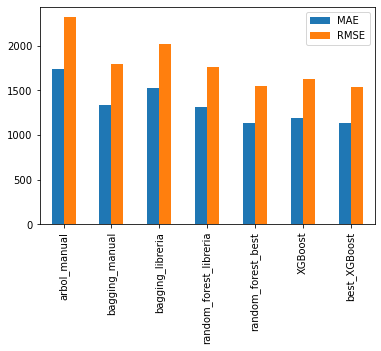

In [29]:
# Celda 8
df_resultados = pd.DataFrame(resultados_modelos).T
display(df_resultados)
df_resultados.plot(kind="bar").

['Year' 'Mileage' 'M_Camry' 'M_Camry4dr' 'M_CamryBase' 'M_CamryL'
 'M_CamryLE' 'M_CamrySE' 'M_CamryXLE']


<AxesSubplot:>

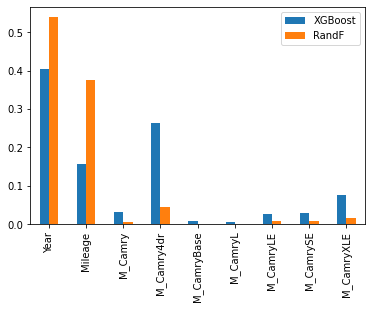

In [30]:
print(clf.feature_names_in_)
clf.feature_importances_


dict_feature_importances = {"XGBoost":clf.feature_importances_,
"RandF":RF_grid.best_estimator_.feature_importances_}

pd.DataFrame(dict_feature_importances, index=X_train.columns.values).plot(kind="bar")